# Прогноз оттока клиентов

## Описание задачи

  Отдел маркетинга провел исследование и выяснил, что в последнее время из компании все чаще начали уходить клиенты к конкурентам. Стоимость маркетинговых затрат на возврат ушедшего клиента весьма высока, дешевле удержать клиента.
  
  Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
  
  В связи с этим <i>необходимо разработать модель прогнозирования оттока клиентов</i>.

### План работы

1. Загрузка данных.
2. Предобработка данных - работа с пропусками, дубликатами и так далее.
3. Исследовательский анализ, который включает в себя поиск аномальных значений, анализ полезных признаков, выявление закономерностей.
4. Построение и обучение моделей с подбором гиперпараметров. RandomForest, LightGBM и полносвязную нейронную сеть.
5. Тестирование лучшей модели.

### Цель проекта

Небходимо построить и обучить модель, которая спрогнозирует уход клиента. Используя метрику ROC-AUC, необходимо добиться точности модели не менее 0.75.

## Загрузка данных

Имортируем необходимые библиотеки для анализа данных:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import phik
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

from optuna.distributions import LogUniformDistribution, IntUniformDistribution, CategoricalDistribution
from optuna.integration import OptunaSearchCV
import optuna

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

У нас в распоряжении 4 таблицы:
 * contract.csv - информация о договоре;
 * internet.csv - информация об интернет-услугах;
 * personal.csv - персональные данные клиента;
 * phone.csv - информация об услугах телефонии.

In [2]:
path = 'C:/Users/79283/Desktop/project/final_provider/'

contract = pd.read_csv(path + 'contract.csv')
internet = pd.read_csv(path + 'internet.csv')
personal = pd.read_csv(path + 'personal.csv')
phone = pd.read_csv(path + 'phone.csv')

del path

В следующих пунктах мы выведем по 5 строк каждой таблицы для оценки столбцов, а также общую информацию для проверки на типы данных и пропуски. Затем посчитаем дубликаты.

### Contract

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Описание столбцов:
 * customerID - id клиента
 * BeginDate - дата подписания договора
 * EndDate - дата расторжения договора
 * Type - тип платежа за услуги
 * PaperlessBilling - безбумажное выставление счетов
 * PaymentMethod - способ оплаты
 * MonthlyCharges - сумма ежемесячных платежей
 * TotalCharges - общая сумма платежей

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропуски в данных отсутствуют.

### Internet

In [5]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Описание столбцов:
 * customerID - id клиента
 * InternetService - тип подключения
 * OnlineSecurity - блокировка небезопасных сайтов
 * OnlineBackup - облачное хранилище файлов для резервного копирования данных
 * DeviceProtection - антивирус
 * Tech Support - выделенная линия технической поддержки
 * StreamingTV - стриминговое телевидение
 * StreamingMovies - каталог фильмов

In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропуски отсутствуют.

### Personal

In [7]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Описание столбцов:
 * customerID - id клиента
 * gender - пол пользователя
 * SeniorCitizen - пенсионер ли пользователь
 * Partner - есть ли партнер
 * Dependents - нетрудоспособный (инвалид/на попечении у кого-то)

In [8]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков нет.

### Phone

In [9]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Описание столбцов:
 * customerID - id клиента
 * MultipleLines - стационарная телефонная связь (услуга)

In [10]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [11]:
phone.columns = ['customer_id', 'multiple_lines']

## Предобработка данных

### Таблица Contract

**EndDate** - указывает на наш целевой признак. Сама дата нам не скажет многого, но нам необходим факт того что клиент расторгнул договор. Создадим отдельный столбец в котором будут всего 2 значения (0 и 1).

Создадим целевой признак - столбец **is_out**. В нем будет всего 2 класса.

In [12]:
contract['is_out'] = [0 if x=='No' else 1 for x in contract['EndDate']]
contract['is_out'].value_counts()

0    5174
1    1869
Name: is_out, dtype: int64

Так же для удобной работы нужно будет привести названия столбцов к привычному стилю:

In [13]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 
                    'payment_method', 'monthly_charges', 'total_charges', 'is_out']
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'is_out'],
      dtype='object')

Столбец **total_charges** нельзя привести к *float* из за строковых пробелов. Посмотрим сколько их:

In [14]:
contract[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,is_out
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0


Все эти строки связывает то что договор подписан 2020-02-01. Суть в том что вся информация из таблиц актуальна как раз до этой даты. Значит эти люди просто не успели ничего оплатить. Будет вполне логично заполнить эти пропуски нулями.

In [15]:
contract['total_charges'] = contract['total_charges'].replace(' ', 0)

Теперь можно изменить тип данных без ошибок:

In [16]:
contract['total_charges'] = contract['total_charges'].astype(float)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   is_out             7043 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 495.3+ KB


В будущем мы создадим столбец с длительностью договора в днях, для этого нам потребуется перевести столбцы с датой в нужный тип данных, сделаем это.

Значения 'No' в столбце **end_date** означают, что пользователь все еще пользуется услугами, но так как нам нужна дата для перевода столбца в нужный тип - изменим это значения на последнюю актуальную дату - *2020-02-01*.

In [17]:
contract['end_date'] = contract['end_date'].str.replace('No', '2020-02-01')

contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')

Остальные столбцы, которые могут нуждаться в изменении типа (например **PaperlessBilling**), все равно по итогу будут закодированы в дальнейшем.

Рассмотрим уникальные значения столбцов для выявления ошибок в данных:

In [18]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

In [19]:
contract['paperless_billing'].value_counts()

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

In [20]:
contract['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Посчитаем дубликаты:

In [21]:
contract['customer_id'].duplicated().sum()

0

Дубликаты отсутствуют.

**Выводы**

 * is_out - целевой признак
 * Переименовали столбцы
 * Изменили тип данных некоторых столбцов
 * Проверили таблицу на ошибки, пропуски, дубликаты и исправили

### Таблица Internet

Переименуем столбцы:

In [22]:
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup', 
                    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

Поищем ошибки в данных, посмотрев на уникальные значения столбцов:

In [23]:
for column in internet.columns[1:]:
    print(column.upper())
    print(internet[column].value_counts(), '\n')

INTERNET_SERVICE
Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64 

ONLINE_SECURITY
No     3498
Yes    2019
Name: online_security, dtype: int64 

ONLINE_BACKUP
No     3088
Yes    2429
Name: online_backup, dtype: int64 

DEVICE_PROTECTION
No     3095
Yes    2422
Name: device_protection, dtype: int64 

TECH_SUPPORT
No     3473
Yes    2044
Name: tech_support, dtype: int64 

STREAMING_TV
No     2810
Yes    2707
Name: streaming_tv, dtype: int64 

STREAMING_MOVIES
No     2785
Yes    2732
Name: streaming_movies, dtype: int64 



Ошибки отсутствуют, посчитаем дубликаты:

In [24]:
internet['customer_id'].duplicated().sum()

0

Дубликаты отсутствуют.

### Таблица Personal

Переименуем столбцы:

In [25]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

Проверим уникальные значения аналогично прошлой таблице:

In [26]:
for column in personal.columns[1:]:
    print(column.upper())
    print(personal[column].value_counts(), '\n')

GENDER
Male      3555
Female    3488
Name: gender, dtype: int64 

SENIOR_CITIZEN
0    5901
1    1142
Name: senior_citizen, dtype: int64 

PARTNER
No     3641
Yes    3402
Name: partner, dtype: int64 

DEPENDENTS
No     4933
Yes    2110
Name: dependents, dtype: int64 



In [27]:
personal['customer_id'].duplicated().sum()

0

Ни дубликатов, ни ошибок в таблице нет.

Таблица **phone** не нуждается в предобработке.

## Исследовательский анализ

### Объединение таблиц

Таблицы **phone** и **internet** связаны - это услуги предоставляемые клиентам. Следовательно объединив эти таблицы по идентификатору клиента, мы получим все 7043 строки.

In [28]:
internet_phone = internet.merge(phone, on='customer_id', how='outer')
internet_phone.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,No


Необходимо разобраться с пропусками. Если клиент не присутствовал в таблице **phone**, значит он не использовал эту услугу, значит пропуск в столбце *MultipleLines* можно заменить на "No". По этой логике мы обработаем остальные пропуски.

In [29]:
internet_phone = internet_phone.fillna('No')

Объеденим все таблицы в одну, для получения сырых признаков для будущих моделей.

In [30]:
full = (contract.merge(personal, on='customer_id')
                .merge(internet_phone, on='customer_id'))
full.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,is_out,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


Создадим дополнительный столбец, который будет показывать время "жизни" клиента в днях, с целью улучшения качества модели:

In [31]:
full['duration'] = (full['end_date'] - full['begin_date']).dt.days
full.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,is_out,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,No,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,Fiber optic,No,No,No,No,No,No,No,61


Теперь можно избавиться от дат и идентификатора:

In [32]:
full = full.drop(['begin_date', 'end_date', 'customer_id'], axis=1)
full.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,is_out,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31
1,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61


### Аномальные значения

В таблице **contract** присутствуют количественные столбцы, стоит рассмотреть в них аномальные значения. Используем график *boxplot* для оценки.

Сперва рассмотрим распределение значений в столбце **duration**:

AxesSubplot(0.125,0.125;0.775x0.755)


count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: duration, dtype: float64

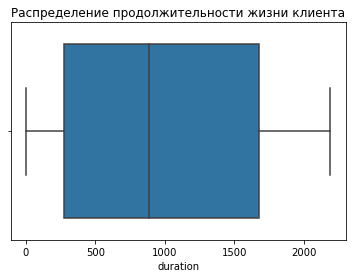

In [33]:
print(sns.boxplot(full['duration']))
plt.title('Распределение продолжительности жизни клиента')
full['duration'].describe()

Теперь **monthly_charges**:

AxesSubplot(0.125,0.125;0.775x0.755)


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

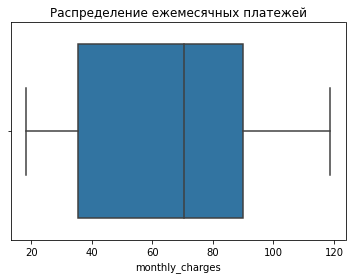

In [34]:
print(sns.boxplot(contract['monthly_charges']))
plt.title('Распределение ежемесячных платежей')
contract['monthly_charges'].describe()

Аномальные значения отсутствуют, теперь рассмотрим распределение общих сумм выплат:

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

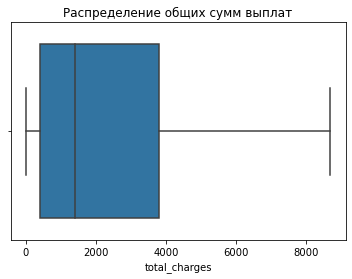

In [35]:
sns.boxplot(contract['total_charges'])
plt.title('Распределение общих сумм выплат')
contract['total_charges'].describe()

Медиана смещена влево. Возможно в больших значениях стоят люди, которые платят сразу за год/за два. Выведем тот же график, но теперь в зависимости от типа платежа:

<AxesSubplot:xlabel='total_charges', ylabel='type'>

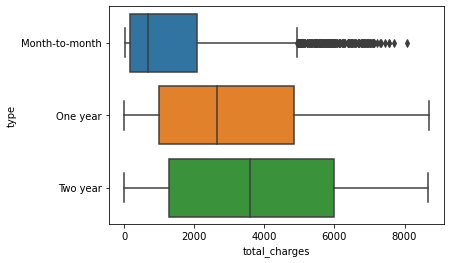

In [36]:
sns.boxplot(data=full, x='total_charges', y='type')

Так и оказалось, также у типа *Month-to-month* присутствуют редкие значения. Рассмотрим гистограмму, чтобы оценить выбросы:

<AxesSubplot:xlabel='total_charges', ylabel='Count'>

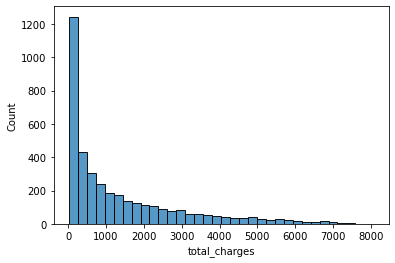

In [37]:
sns.histplot(full[full['type']=='Month-to-month']['total_charges'])

Редких значений достаточно много, можно вырезать значения свыше 3000.

<AxesSubplot:xlabel='total_charges', ylabel='type'>

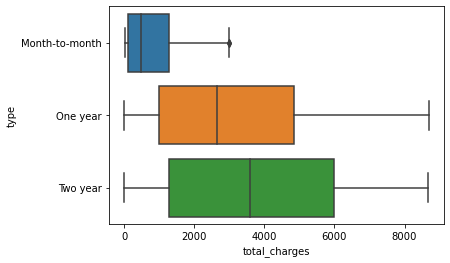

In [38]:
outliers_indexes = full[(full['type']=='Month-to-month') & (full['total_charges'] > 3000)].index

full = full.drop(outliers_indexes).reset_index(drop=True)

sns.boxplot(data=full, x='total_charges', y='type')

### Кодировка столбцов

Будем создавать признаки для обучения моделей, для этого необходимо провести кодировку данных.

Кодировать данные будем техникой **OrdinalEncoding**:

In [39]:
encoder = OrdinalEncoder()
column_names = full.drop(['total_charges', 'monthly_charges', 'duration'], axis=1).columns

full_oe = pd.DataFrame(encoder.fit_transform(full[column_names]), columns=column_names)
full_oe['monthly_charges'] = full['monthly_charges']
full_oe['total_charges'] = full['total_charges']
full_oe['duration'] = full['duration']
full_oe.head()

,type,paperless_billing,payment_method,is_out,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,monthly_charges,total_charges,duration
0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,29.85,29.85,31
1,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,56.95,1889.50,1036
2,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,53.85,108.15,61
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,42.30,1840.75,1371
4,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.70,151.65,61


Прежде чем делить данные, тщательнее проанализируем признаки, скорее всего мы не будем использовать их все.

### Анализ взаимосвязей


Посмотрим распределение каждого признака с заливкой по целевому признаку, с целью выявить и отбросить наименее полезные признаки:

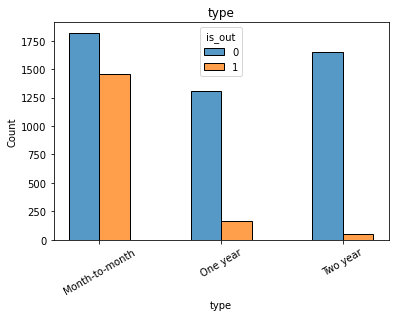

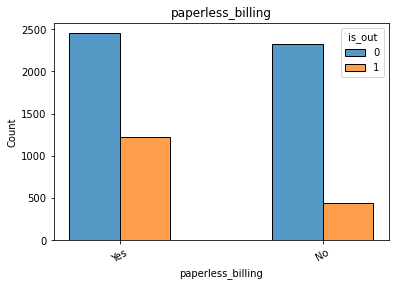

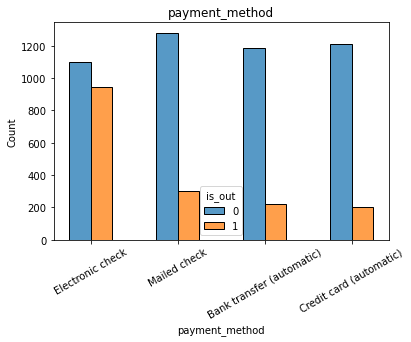

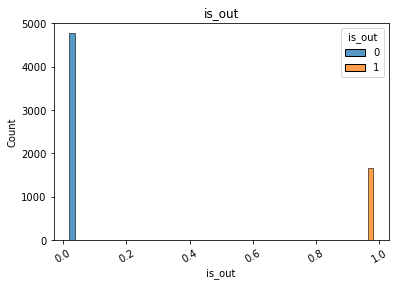

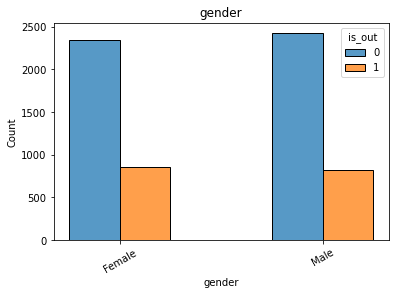

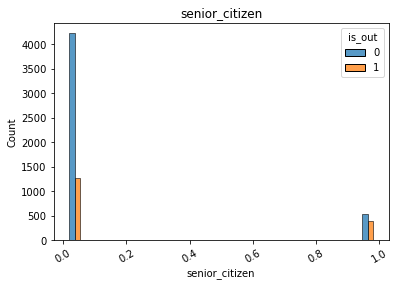

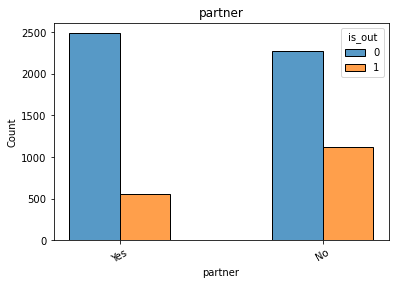

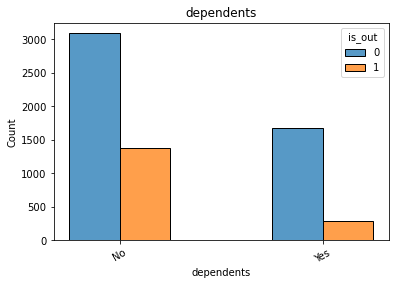

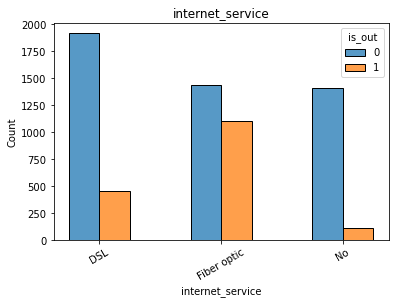

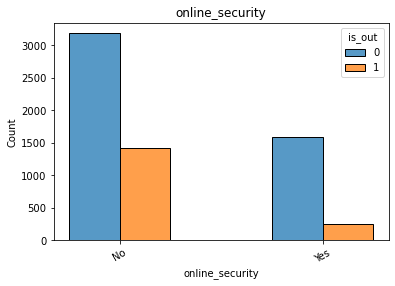

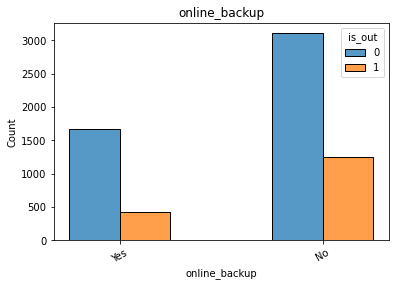

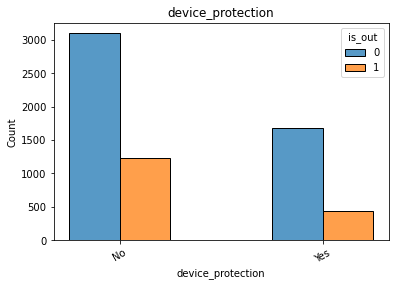

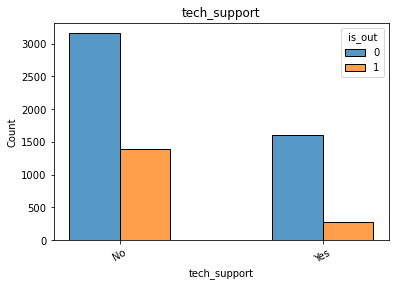

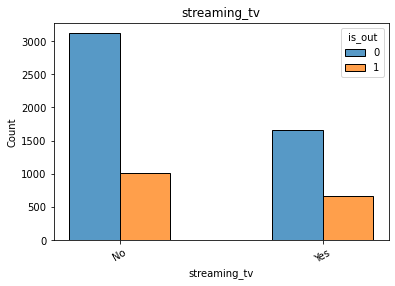

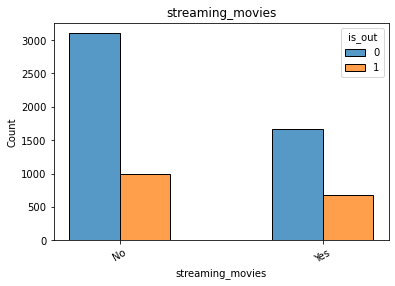

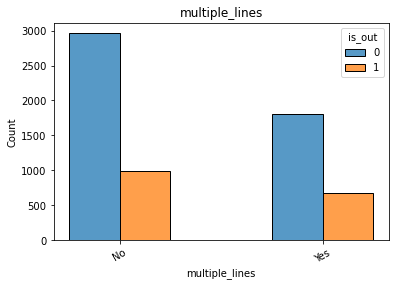

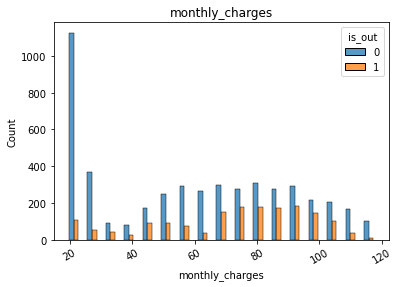

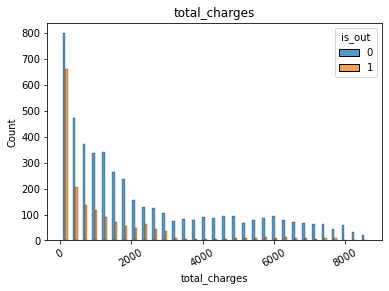

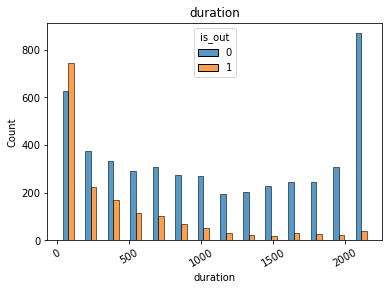

In [40]:
for column in full_oe.columns:
    sns.histplot(data=full, x=column, hue='is_out', multiple='dodge', shrink=0.5)
    plt.xticks(rotation=30)
    plt.title(column)
    plt.show()

За последние годы количество ушедших очень сильно повысилось.

Cледует обратить внимание на гистограмму столбца *total_charges*. Слишком много людей в маленьких значениях: ушедших и неушедших. Большое количество ушедших можно объяснить тем, что человек в первый же месяц сделает выводы об услуге и он перестанет ей пользоваться, потому *total_charges* будет низким у ушедших людей. Можно нагляднее посмотреть по каким причинам они уходят так рано:

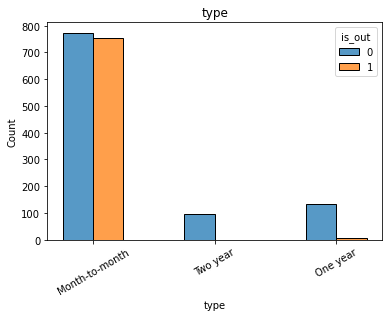

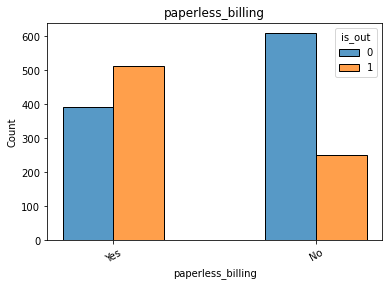

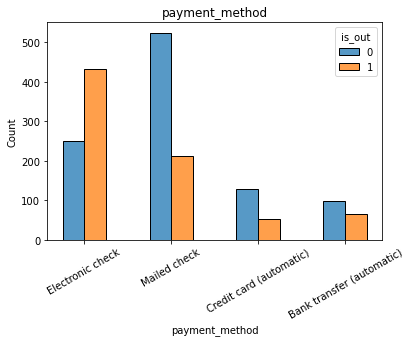

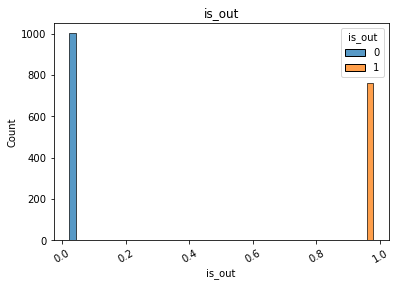

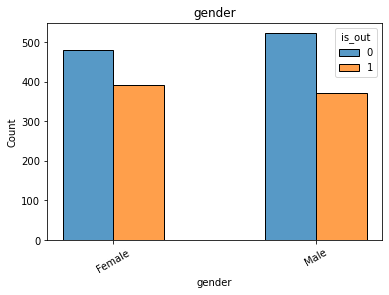

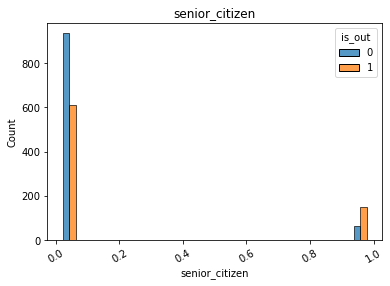

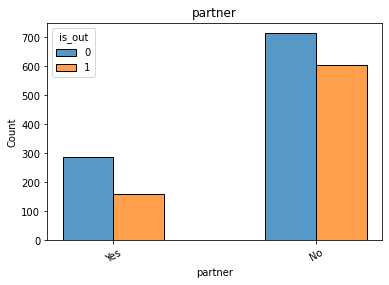

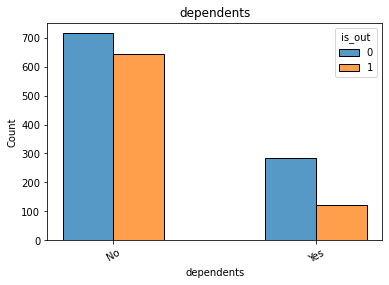

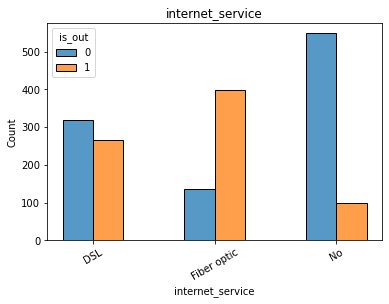

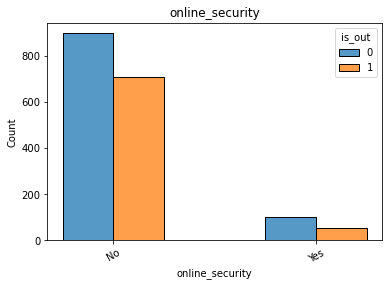

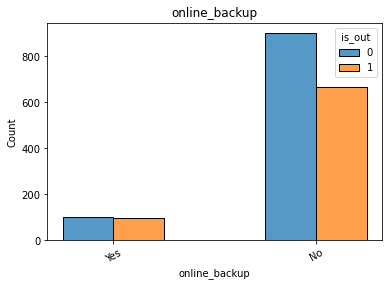

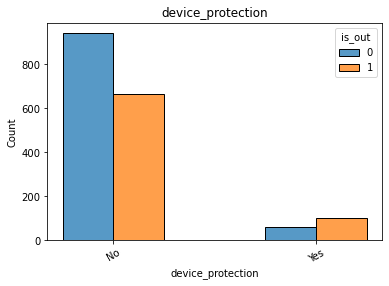

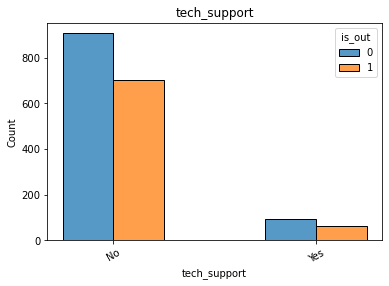

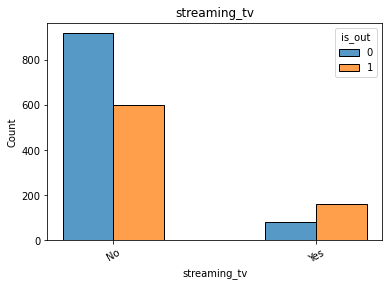

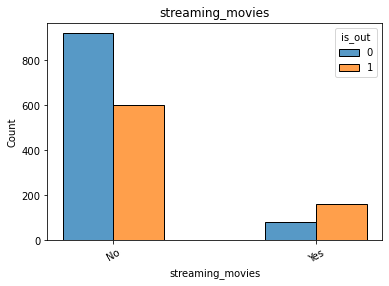

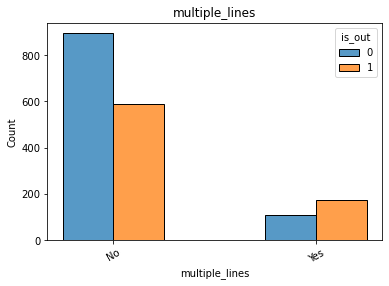

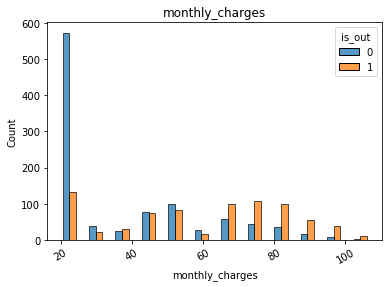

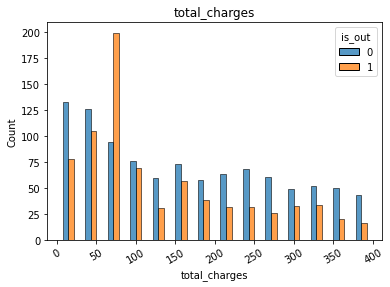

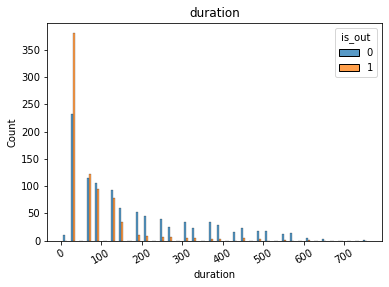

In [41]:
for column in full_oe.columns:
    sns.histplot(data=full[full['total_charges'] < 400], x=column, hue='is_out', multiple='dodge', shrink=0.5)
    plt.xticks(rotation=30)
    plt.title(column)
    plt.show()

График сильно отличается, построим графики по остальным значениям *total_charges*, чтобы легче было сравнивать:

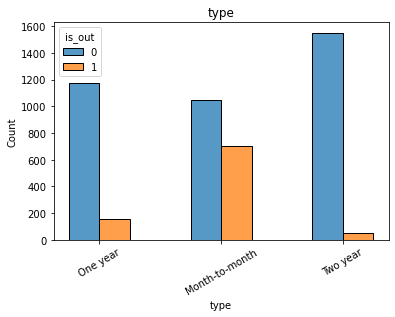

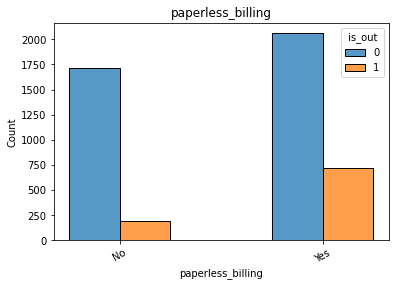

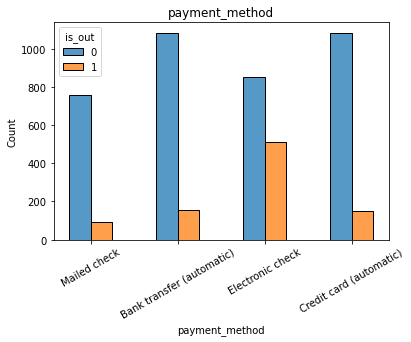

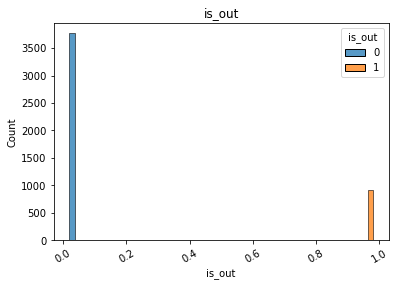

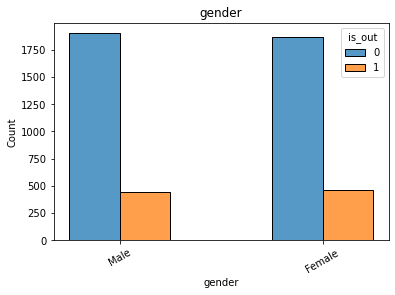

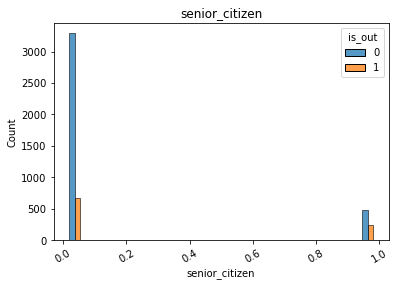

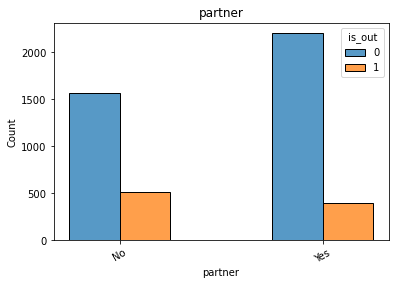

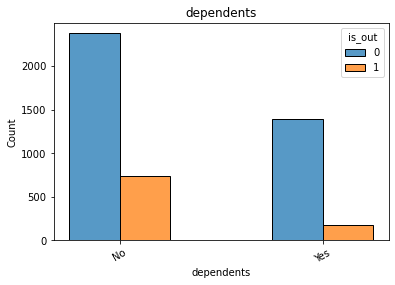

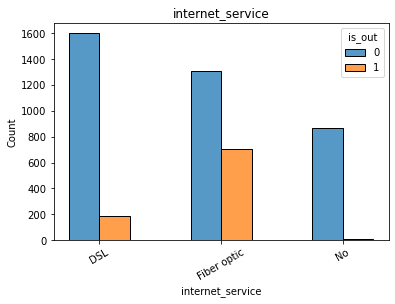

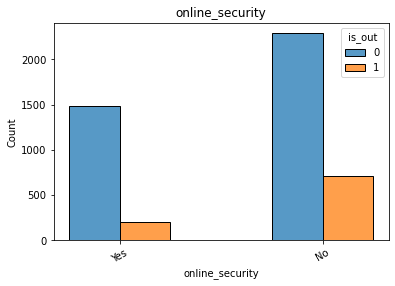

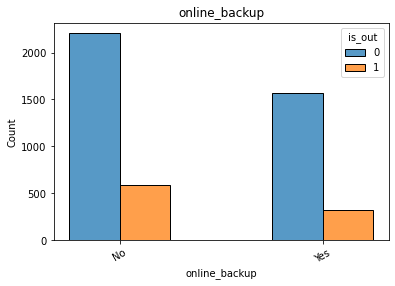

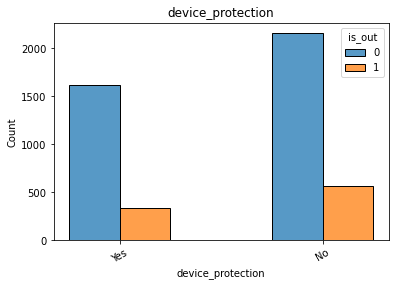

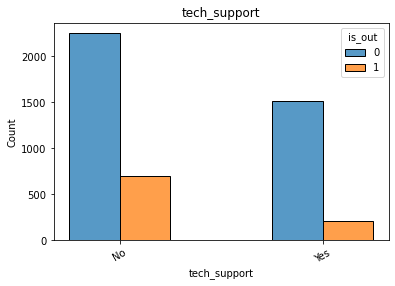

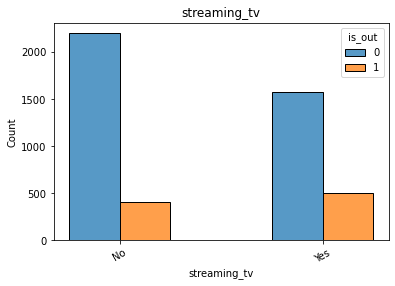

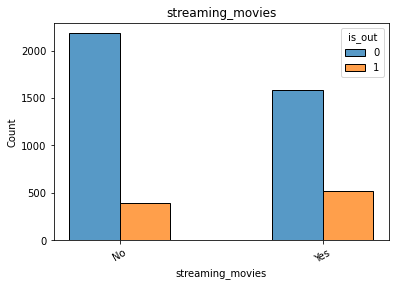

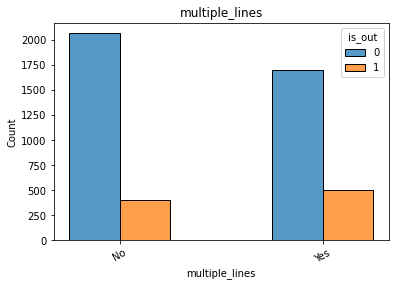

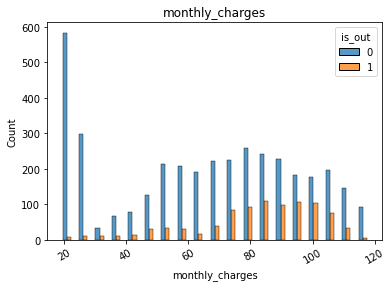

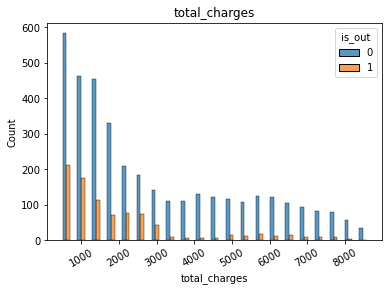

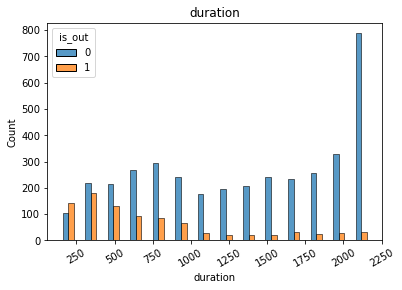

In [42]:
for column in full_oe.columns:
    sns.histplot(data=full[full['total_charges'] >= 400], x=column, hue='is_out', multiple='dodge', shrink=0.5)
    plt.xticks(rotation=30)
    plt.title(column)
    plt.show()

Отлично! Мы выявили важную информацию о признаках, которые сильнее остальных влияют на уход:
 * Клиенты стали массово уходить за последние несколько лет
 * Люди с типом платежа Month-to-month, уходят гораздо чаще остальных типов
 * Безбумажный расчет
 * Электронный чек
 * Часто - высокая ежемесячная плата
 * У этих людей часто стоит Fiber optic (оптическое волокно)
 * Люди уходят в первые же месяцы, это объясняет скопление ушедших в начале графика распределения общих сумм выплат.

Все остальные признаки не повлияли на уход клиента. Однако, чтобы точно в этом убедиться посмотрим как признаки друг на друга влияют с помощью библиотеки **phik**.

В дальнейшем мы будем использовать псевдослучайность, зададим константу для этого:

In [43]:
RANDOM_STATE = 80822

Зададим признаки:

In [44]:
features = full_oe.drop(['is_out'], axis=1)
target = full_oe['is_out']

Разделим признаки на обучающую, валидационную и тестовую выборки в соотношении размеров 3:1:1

In [45]:
train_x, valid_x, train_y, valid_y = train_test_split(features, target, 
                                                    test_size=0.2, random_state=RANDOM_STATE)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, 
                                                   test_size=0.25, random_state=RANDOM_STATE)

Убедимся в том, что получили нужные размеры выборок:

In [46]:
print('Обучающая -', train_x.shape)
print('Валидационная -', valid_x.shape)
print('Тестовая -', test_x.shape)

Обучающая - (3866, 18)
Валидационная - (1289, 18)
Тестовая - (1289, 18)


Используем библиотеку **phik** для проверки на мультиколлинеарность признаков. Выведем тепловую карту:

interval columns not set, guessing: ['type', 'paperless_billing', 'payment_method', 'is_out', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'monthly_charges', 'total_charges', 'duration']


<AxesSubplot:>

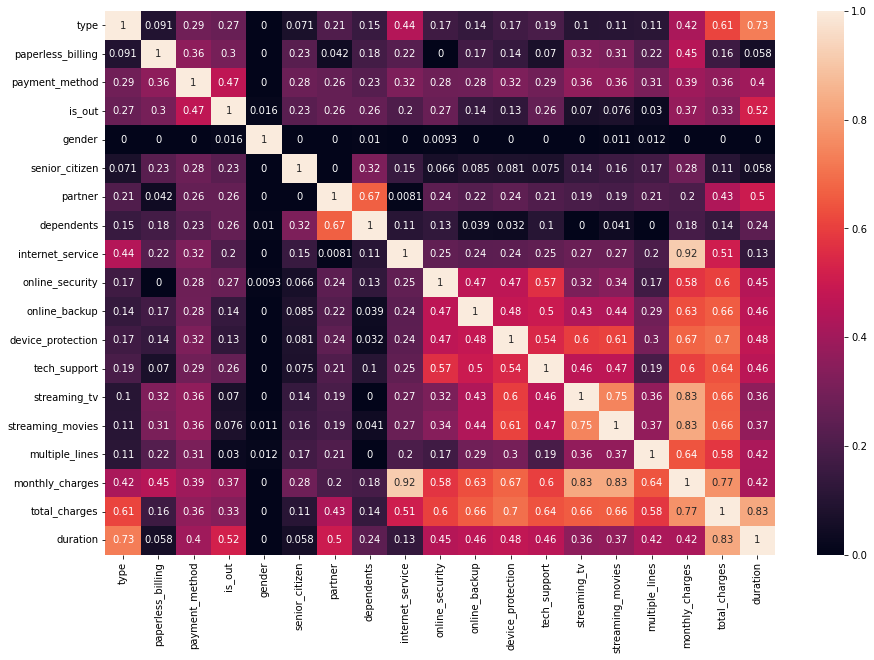

In [47]:
plt.figure(figsize=(15,10))
sns.heatmap(full_oe.phik_matrix(), annot=True)

Обнаружены следующие пары взаимосвязей:

1. Наличие партнера - инвалидность
2. Ежемесячные платежи - тип подключения
3. Все интернет-услуги коррелируют между собой
4. Ежемесячные платежи - общие выплаты

Удалим по одному признаку из каждой пары, а именно столбцы: 

* dependents
* monthly_charges
* online_security
* online_bacup
* device_protection
* tech_support
* streaming_tv
* streaming_movies

Посмотрим какие признаки, не считая вышеперечисленных, не влияют на целевой признак:

* gender
* multiple_lines

Оставим нужные признаки:

In [48]:
usefull_features = ['type', 'paperless_billing', 'payment_method', 'senior_citizen',
                    'partner', 'internet_service', 'total_charges', 'duration']
   
train_x = train_x[usefull_features]
valid_x = valid_x[usefull_features]
test_x = test_x[usefull_features]

train_x.head()

,type,paperless_billing,payment_method,senior_citizen,partner,internet_service,total_charges,duration
604,0.0,0.0,3.0,0.0,0.0,0.0,428.70,306
5484,0.0,0.0,2.0,0.0,0.0,0.0,1004.75,883
2330,2.0,1.0,1.0,0.0,0.0,1.0,7795.95,2132
4120,2.0,0.0,1.0,0.0,1.0,0.0,6595.90,2191
3189,0.0,0.0,2.0,0.0,0.0,0.0,214.55,123


Столбцы с датами, как говорилось ранее, мы вносить в признаки не будем.

### Дисбаланс классов

Создадим пару вариантов признаков, в будущем проверим какой из них дает лучший результат.

Устраняя дисбаланс классов мы будем использовать **Upsampling** и обычный **class_weight**. Для начала посмотрим на различия в балансе:

In [49]:
train_y.value_counts()

0.0    2837
1.0    1029
Name: is_out, dtype: int64

Единиц почти в 3 раза меньше. Напишем функцию которая будет увеличивать единички копированием объектов:

In [50]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
                        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Применим ее, увеличив количество единичек в 2 раза:

In [51]:
x_upsampled, y_upsampled = upsample(train_x, train_y, 2)
y_upsampled.value_counts()

0.0    2837
1.0    2058
Name: is_out, dtype: int64

Баланс классов проведен.

## Построение моделей

Для каждой модели будем искать гиперпараметры инструментов **OptunaSearchCV**. А затем по этим параметрам будем тестировать на валидационной выборке.

Настройка optuna, при которой будет отсутствовать отображение процесса подбора гиперпараметров (занимает невероятно много места):

In [52]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

### RandomForestClassifier

Функция для поиска гиперпараметров для экономии кода:

In [53]:
def get_best_model_rf(X, Y, class_weight=None):
    params = {'n_estimators': IntUniformDistribution(4, 25),
              'max_depth': IntUniformDistribution(3,15),
              'min_samples_leaf': IntUniformDistribution(2, 16),
              'min_samples_split': IntUniformDistribution(2, 16),
              'max_features': CategoricalDistribution(['log2', 'sqrt']),
              'bootstrap': CategoricalDistribution(['True', 'False'])}

    search = OptunaSearchCV(RandomForestClassifier(random_state=RANDOM_STATE,
                                                       class_weight=class_weight),
                                param_distributions=params,
                                scoring='roc_auc',
                                n_trials=400,
                                timeout=600,
                                random_state=RANDOM_STATE)
    search.fit(X, Y)
    
    print('roc_auc =', abs(search.best_score_))
    return search.best_estimator_, search.best_params_

В дальнейшем мы будем использовать две обучающие выборки. Внутренний баланс, где в настройке модели мы присваиваем *class_weight = 'balanced'*, и Upsampling, где используем сбалансированную выборку.

#### Внутренний баланс классов

Баланс классов будет осуществлять сама модель, мы присвоим ей гиперпараметр **class_weight='balanced'**, то есть обучим ее на *train_x*. Гиперпараметры будем подбирать инструментом **OptunaSearchCV**:

In [54]:
rf, params = get_best_model_rf(train_x, train_y, class_weight='balanced')
print('Лучшие параметры: \n', params)

roc_auc = 0.8727326954582612
Лучшие параметры: 
 {'n_estimators': 17, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 'log2', 'bootstrap': 'True'}


Протестируем на валидационной выборке:

In [55]:
rf.fit(train_x, train_y)

probs = rf.predict_proba(valid_x)
probs = probs[:, 1]
rf_result = roc_auc_score(valid_y, probs)
print('Прогноз по валидационной выборке: \n', rf_result)

Прогноз по валидационной выборке: 
 0.8759606817555399


**Значение метрики - 0.876**

#### Upsampling

In [56]:
rf2, params2 = get_best_model_rf(x_upsampled, y_upsampled)
print('Лучшие параметры: \n', params)

roc_auc = 0.9242730123711371
Лучшие параметры: 
 {'n_estimators': 17, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 'log2', 'bootstrap': 'True'}


Показывает немного лучшую точность, посмотрим что будет на тесте валидационной выборки:

In [57]:
rf2.fit(x_upsampled, y_upsampled)

probs = rf2.predict_proba(valid_x)
probs = probs[:, 1]
rf_result2 = roc_auc_score(valid_y, probs)
print('Прогноз по валидационной выборке: \n', rf_result2)

Прогноз по валидационной выборке: 
 0.8660542020011667


**Значение метрики - 0.866**

### LGBMClassifier

Функция для нахождения гиперпараметров:

In [58]:
def get_best_model_lgbm(X, Y, class_weight=None):
    params = {'n_estimators': IntUniformDistribution(4, 25),
              'max_depth': IntUniformDistribution(3,15),
              'learning_rate': LogUniformDistribution(0.1, 1),
              'reg_alpha': LogUniformDistribution(0.1, 1)}

    search = OptunaSearchCV(LGBMClassifier(random_state=RANDOM_STATE,
                                           class_weight=class_weight,
                                           force_row_wise=True),
                                param_distributions=params,
                                scoring='roc_auc',
                                n_trials=400,
                                timeout=600,
                                random_state=RANDOM_STATE)
    search.fit(X, Y)
    
    print('roc_auc =', abs(search.best_score_))
    return search.best_estimator_, search.best_params_

#### Внутренний баланс классов

In [59]:
lgbm, params = get_best_model_lgbm(train_x, train_y, class_weight='balanced')
print('Лучшие параметры: \n', params)

roc_auc = 0.9022900717128184
Лучшие параметры: 
 {'n_estimators': 24, 'max_depth': 4, 'learning_rate': 0.7088252027070128, 'reg_alpha': 0.5715292577707285}


In [60]:
lgbm.fit(train_x, train_y)

probs = lgbm.predict_proba(valid_x)
probs = probs[:, 1]
lgbm_result = roc_auc_score(valid_y, probs)
print('Прогноз по валидационной выборке: \n', lgbm_result) 

Прогноз по валидационной выборке: 
 0.8928811799319271


**Значение метрики - 0.893**

#### Upsampling

In [69]:
lgbm2, params = get_best_model_lgbm(x_upsampled, y_upsampled)
print('Лучшие параметры: \n', params)

roc_auc = 0.9479807130274726
Лучшие параметры: 
 {'n_estimators': 25, 'max_depth': 14, 'learning_rate': 0.8766786635906021, 'reg_alpha': 0.13502253108756318}


In [62]:
lgbm2.fit(x_upsampled, y_upsampled)

probs = lgbm2.predict_proba(valid_x)
probs = probs[:, 1]
lgbm_result2 = roc_auc_score(valid_y, probs)
print('Прогноз по валидационной выборке: \n', lgbm_result2)

Прогноз по валидационной выборке: 
 0.8980058842759072


**Значение метрики - 0.898**

### Нейронная сеть 

#### Обучение с внутренним балансом

Построим и обучим нейронную сеть и обучим на *train_x*, *train_y*:

In [63]:
optimizer = Adam(learning_rate=0.0002)

model = keras.models.Sequential()

model.add(keras.layers.Dense(units=154, input_dim=train_x.shape[1],
                        activation='relu'))
model.add(keras.layers.Dense(units=54, activation='relu'))
model.add(keras.layers.Dense(units=16, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=keras.metrics.AUC(
                                                                            num_thresholds=200,
                                                                            curve='ROC',
                                                                            summation_method='interpolation'))

model.fit(train_x, train_y, epochs=400, class_weight={0:1, 1:3}, verbose=0)

nn_result = model.evaluate(valid_x, valid_y)[1]
print('Результат на валидационной выборке -', nn_result)

41/41 [==============================] - 0s 648us/step - loss: 0.4753 - auc: 0.8531
Результат на валидационной выборке - 0.8531318306922913


Вся архитектура была построена вручную.

**Значение метрики ~ 0.84**

#### Обучение на сбалансированной выборке

In [64]:
optimizer = Adam(learning_rate=0.0002)

model = keras.models.Sequential()

model.add(keras.layers.Dense(units=154, input_dim=train_x.shape[1],
                        activation='relu'))
model.add(keras.layers.Dense(units=54, activation='relu'))
model.add(keras.layers.Dense(units=16, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=keras.metrics.AUC(
                                                                            num_thresholds=200,
                                                                            curve='ROC',
                                                                            summation_method='interpolation'))

model.fit(x_upsampled, y_upsampled, epochs=200, verbose=0)

nn_result2 = model.evaluate(valid_x, valid_y)[1]
print('Результат на валидационной выборке -', nn_result2)

41/41 [==============================] - 0s 623us/step - loss: 0.5168 - auc_1: 0.8417
Результат на валидационной выборке - 0.8417478799819946


**Значение метрики ~ 0.83**

### Итог

Мы протестировали 3 модели и получили следующие результаты:

In [65]:
index = ['RandomForest', 'LightGBM', 'NN']

columns = ['Balanced', 'Upsampled']

data = [[rf_result, rf_result2],
        [lgbm_result, lgbm_result2],
        [nn_result, nn_result2]]

ft = (pd.DataFrame(data=data,
            index=index,
            columns=columns)
        .style
        .highlight_max(color='yellowgreen')
        .highlight_min(color='red'))
ft

,Balanced,Upsampled
RandomForest,0.875961,0.866054
LightGBM,0.892881,0.898006
NN,0.853132,0.841748


LightGBM имеет лучшую точность обучаясь на выборке *upsampled* - 0.898

Посмотрим какие признаки оказались наиболее важными или бесполезными:

<AxesSubplot:>

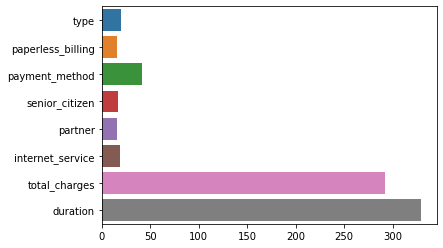

In [66]:
sns.barplot(x=lgbm2.feature_importances_, y=train_x.columns)

Наиболее влиятельные признаки оказались:
1. Продолжительность жизни клиента
2. Общая сумма выплат
3. Метод оплаты

## Тестирование

In [67]:
probs = lgbm2.predict_proba(test_x)
probs = probs[:, 1]
roc_auc_score(test_y, probs)

0.9084811741769167

**Итоговая метрика - ROC_AUC - равна 0.908**

Text(0.5, 1.0, 'ROC-кривая')

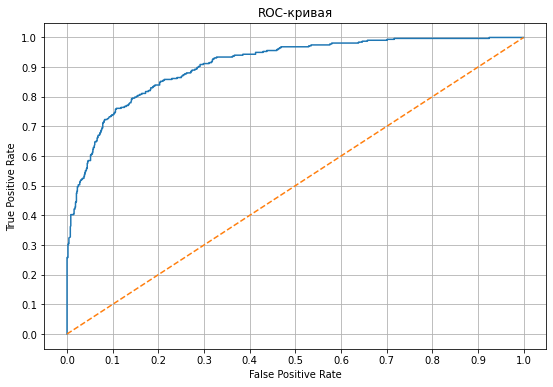

In [68]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_y, probs)

plt.figure(figsize=(9,6))
plt.grid(True)
plt.xticks(np.arange(0,1.01,0.1))
plt.yticks(np.arange(0,1.01,0.1))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--') 
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-кривая')

Цель выполнена, модель может прогнозировать уход клиента.